In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

We will experiment with spectral_modified (bc irrelevant attributes add noise in the proximity measure and redundant attributes add bias towards certain attributes) with cosine distance (bc of high dimensionality) and umap_modified with euclidean distance (15 dimensions)

In [2]:
datasets = datasets_utils.load_datasets()
sub_datasets = filter(lambda x: x.name in {'spectral_modified', 'umap_modified'}, datasets)
datasets_wrapper = datasets_utils.DatasetsWrapper(sub_datasets)

In [3]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_modified,"(20714, 196)","(2397, 196)","(5993, 196)","(20714,)","(2397,)","(5993,)"
umap_modified,"(20714, 15)","(2397, 15)","(5993, 15)","(20714,)","(2397,)","(5993,)"


Since we will be using the Euclidean distance, brining the features of the dataset to the same scale is required

In [4]:
scaler = MinMaxScaler()
datasets_wrapper.scale_datasets(scaler=scaler)

# 1. KNN on Spectral Featres - Dataset

In [5]:
spectral_dataset = datasets_wrapper.get_dataset('spectral_modified')

The Genre 'Easy Listening' is underrepresented (only 12 tracks belong to this genre) and hence the $k$ parameter in our KNN classifier should roughly be around $10$.
We will experiment with different values

In [6]:
spectral_dataset.train.y.value_counts().sort_values()[:3]

(genre, Unnamed: 253_level_1, Unnamed: 253_level_2)
Easy Listening     15
Spoken            200
Blues             200
Name: count, dtype: int64

We will precompute the distances, to be able to experiment with different hyperparameters more efficiently

In [7]:
def calculate_distances(metric, X, Y=None):
    if Y is not None:
        return pd.DataFrame(pairwise_distances(X=X, Y=Y, metric=metric, n_jobs=5), index=X.index, columns=Y.index)
    return pd.DataFrame(pairwise_distances(X=X, metric=metric, n_jobs=5), index=X.index, columns=X.index)

In [8]:
spectral_train_distances = calculate_distances(metric='cosine', X=spectral_dataset.train.X)

In [9]:
spectral_val_distances = calculate_distances(metric='cosine', X=spectral_dataset.val.X, Y=spectral_dataset.train.X)

In [10]:
spectral_test_distances = calculate_distances(metric='cosine', X=spectral_dataset.test.X, Y=spectral_dataset.train.X)

In [11]:
print(spectral_train_distances.shape, spectral_dataset.train.y.shape)
print(spectral_val_distances.shape, spectral_dataset.val.y.shape)
print(spectral_test_distances.shape, spectral_dataset.test.y.shape)

(20714, 20714) (20714,)
(2397, 20714) (2397,)
(5993, 20714) (5993,)


In [12]:
spectral_distances_dataset = datasets_utils.create_dataset(
    name='spectral_distances_dataset',
    train_X=spectral_train_distances, train_y=spectral_dataset.train.y,
    val_X=spectral_val_distances, val_y=spectral_dataset.val.y,
    test_X=spectral_test_distances, test_y=spectral_dataset.test.y
)

In [13]:
spectral_classifiers_list = list()
for i in range(9, 19):
    spectral_classifiers_list.append(
        classification_utils.ClassifierFactory.create_instance(
            dataset=spectral_distances_dataset,
            classifier=KNeighborsClassifier(n_neighbors=i, weights='distance', algorithm='auto', metric='precomputed'),
        )
    )


spectral_classifiers = classification_utils.ClassifiersCollection(spectral_classifiers_list)

In [14]:
spectral_classifiers.fit_classifiers()

Fitting classifiers...


100%|██████████| 10/10 [01:28<00:00,  8.86s/it]

Done


In [15]:
train_set_results = pd.DataFrame()
test_set_results = pd.DataFrame()
num_neighbors = []
for classifier in spectral_classifiers.get_all_classifiers():
    n_neighbors = classifier.get_clf_evaluation().classifier.n_neighbors
    
    train_scores = classifier.get_clf_evaluation().get_scores(on_sets=['train'], average_type='weighted')
    train_scores.columns = [str(n_neighbors)]
    train_set_results = pd.concat([train_set_results, train_scores], axis=1)

    test_scores = classifier.get_clf_evaluation().get_scores(on_sets=['val'], average_type='weighted')
    test_scores.columns = [str(n_neighbors)]
    test_set_results = pd.concat([test_set_results, test_scores], axis=1)

    num_neighbors.append(str(n_neighbors))

In [16]:
def results_long_format(results, num_neighbors):
    results = results.reset_index()
    results = results.rename(columns={'index': 'metric'})
    results = pd.melt(results, id_vars=['metric'], value_vars=num_neighbors)
    results = results.rename(columns={'variable': '# neighbors'})
    return results

In [17]:
train_set_results = results_long_format(train_set_results, num_neighbors)
test_set_results = results_long_format(test_set_results, num_neighbors)

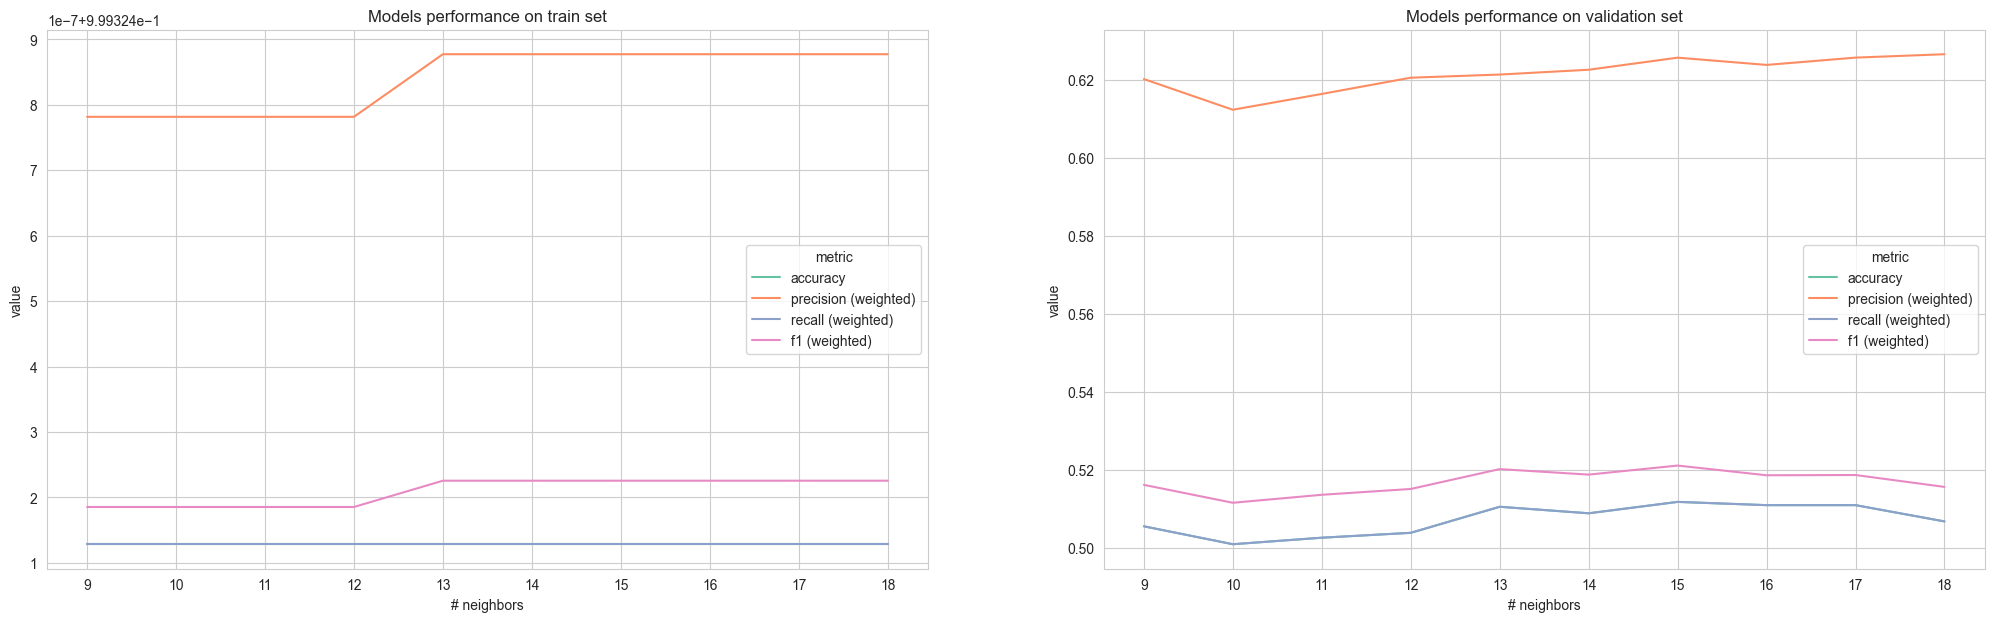

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(25, 7))
sns.lineplot(data=train_set_results, x='# neighbors', y='value', hue='metric', ax=axis[0])
axis[0].set_title('Models performance on train set')
sns.lineplot(data=test_set_results, x='# neighbors', y='value', hue='metric', ax=axis[1])
axis[1].set_title('Models performance on validation set')
plt.show()

In [24]:
knn_clf = classification_utils.ClassifierFactory.create_instance(
    dataset=spectral_distances_dataset,
    classifier=KNeighborsClassifier(n_neighbors=15, weights='distance', algorithm='auto', metric='precomputed'),
)

In [25]:
knn_clf.fit_classifier()

In [27]:
knn_clf.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.999324,0.511890,0.492575
precision (weighted),0.999325,0.625721,0.608028
recall (weighted),0.999324,0.511890,0.492575
f1 (weighted),0.999324,0.521198,0.500730


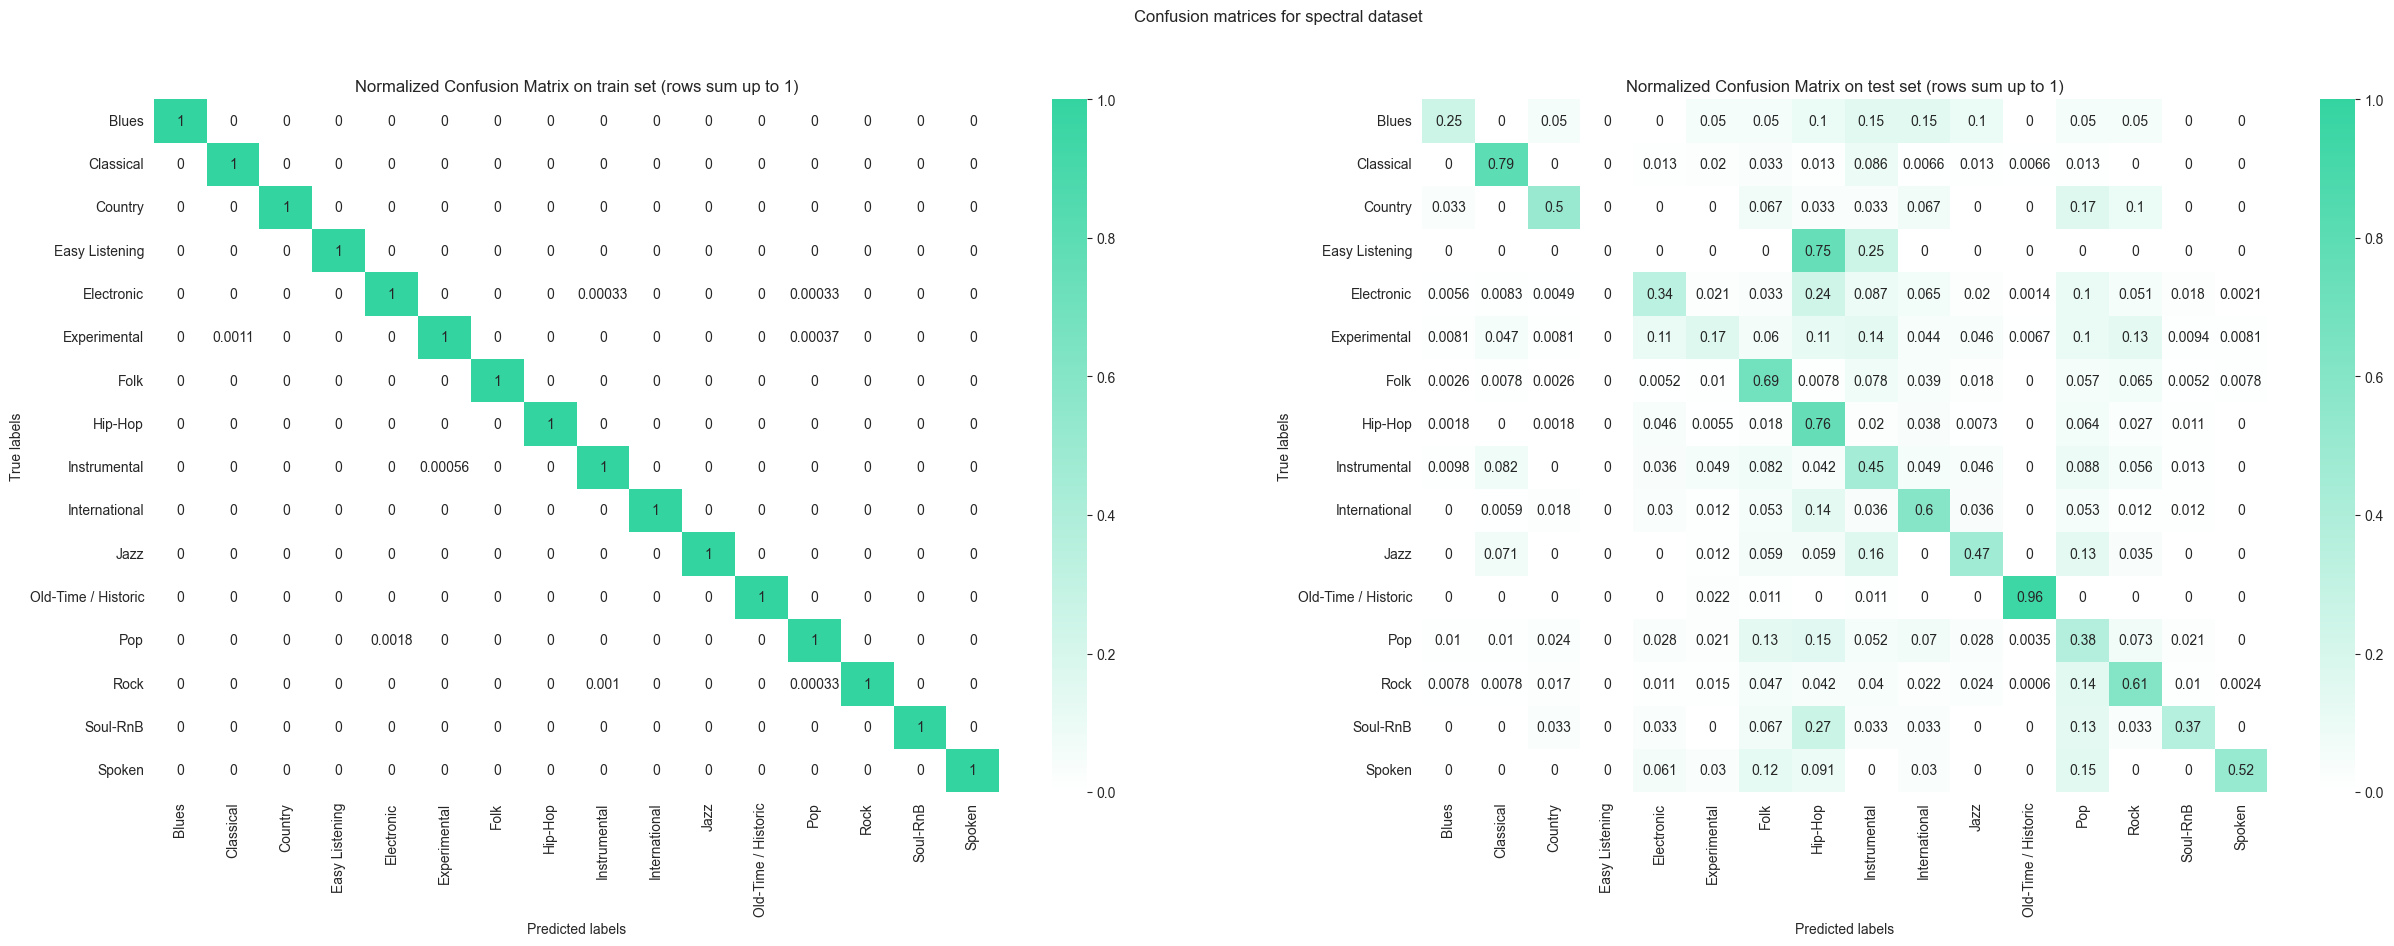

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
knn_clf.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
knn_clf.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Confusion matrices for spectral dataset')
plt.show()

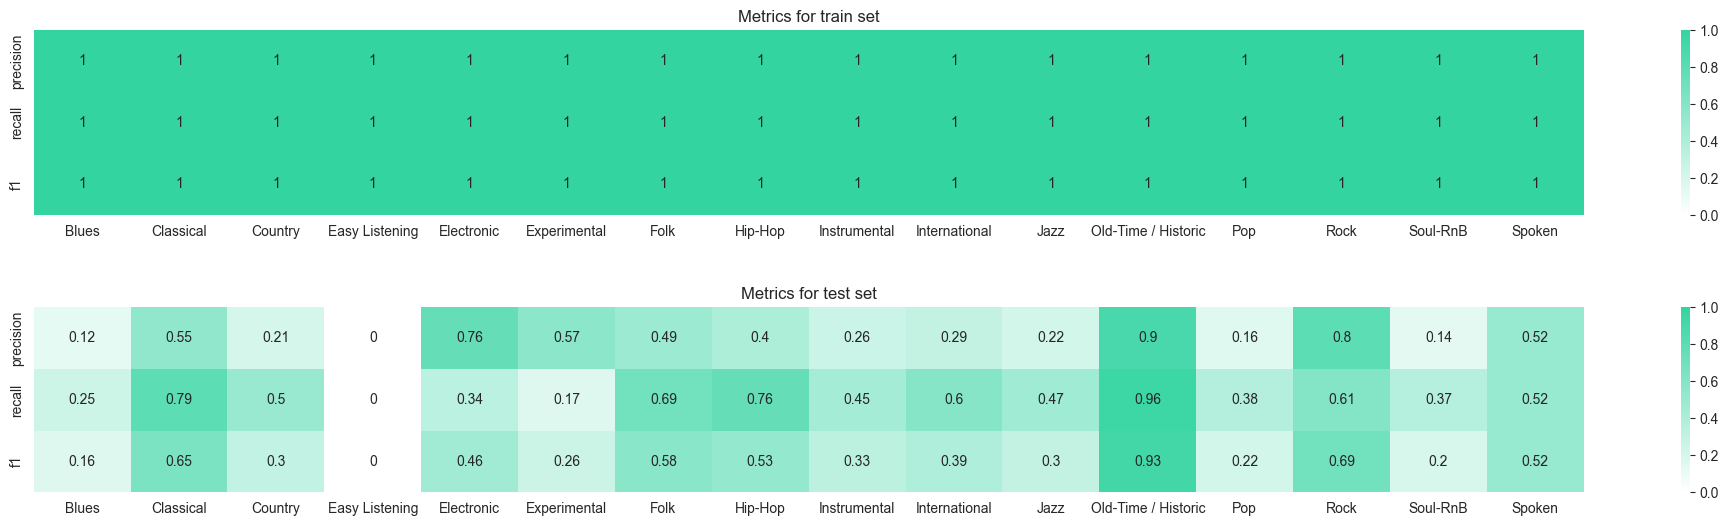

In [30]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
knn_clf.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
knn_clf.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()

# UMAP

In [5]:
umap_dataset = datasets_wrapper.get_dataset('umap_modified')

In [8]:
umap_train_distances = calculate_distances(metric='euclidean', X=umap_dataset.train.X)

In [9]:
umap_val_distances = calculate_distances(metric='euclidean', X=umap_dataset.val.X, Y=umap_dataset.train.X)

In [10]:
umap_test_distances = calculate_distances(metric='euclidean', X=umap_dataset.test.X, Y=umap_dataset.train.X)

In [11]:
print(umap_train_distances.shape, umap_dataset.train.y.shape)
print(umap_val_distances.shape, umap_dataset.val.y.shape)
print(umap_test_distances.shape, umap_dataset.test.y.shape)

(20714, 20714) (20714,)
(2397, 20714) (2397,)
(5993, 20714) (5993,)


In [13]:
umap_distances_dataset = datasets_utils.create_dataset(
    name='umap_distances_dataset',
    train_X=umap_train_distances, train_y=umap_dataset.train.y,
    val_X=umap_val_distances, val_y=umap_dataset.val.y,
    test_X=umap_test_distances, test_y=umap_dataset.test.y
)

In [20]:
umap_classifiers_list = list()
for i in range(16, 25):
    umap_classifiers_list.append(
        classification_utils.ClassifierFactory.create_instance(
            dataset=umap_distances_dataset,
            classifier=KNeighborsClassifier(n_neighbors=i, weights='distance', algorithm='auto', metric='precomputed'),
        )
    )


umap_classifiers = classification_utils.ClassifiersCollection(umap_classifiers_list)

In [21]:
umap_classifiers.fit_classifiers()

Fitting classifiers...


100%|██████████| 9/9 [01:36<00:00, 10.75s/it]

Done


In [22]:
train_set_results = pd.DataFrame()
test_set_results = pd.DataFrame()
num_neighbors = []
for classifier in umap_classifiers.get_all_classifiers():
    n_neighbors = classifier.get_clf_evaluation().classifier.n_neighbors
    
    train_scores = classifier.get_clf_evaluation().get_scores(on_sets=['train'], average_type='weighted')
    train_scores.columns = [str(n_neighbors)]
    train_set_results = pd.concat([train_set_results, train_scores], axis=1)

    test_scores = classifier.get_clf_evaluation().get_scores(on_sets=['val'], average_type='weighted')
    test_scores.columns = [str(n_neighbors)]
    test_set_results = pd.concat([test_set_results, test_scores], axis=1)

    num_neighbors.append(str(n_neighbors))

In [23]:
train_set_results = results_long_format(train_set_results, num_neighbors)
test_set_results = results_long_format(test_set_results, num_neighbors)

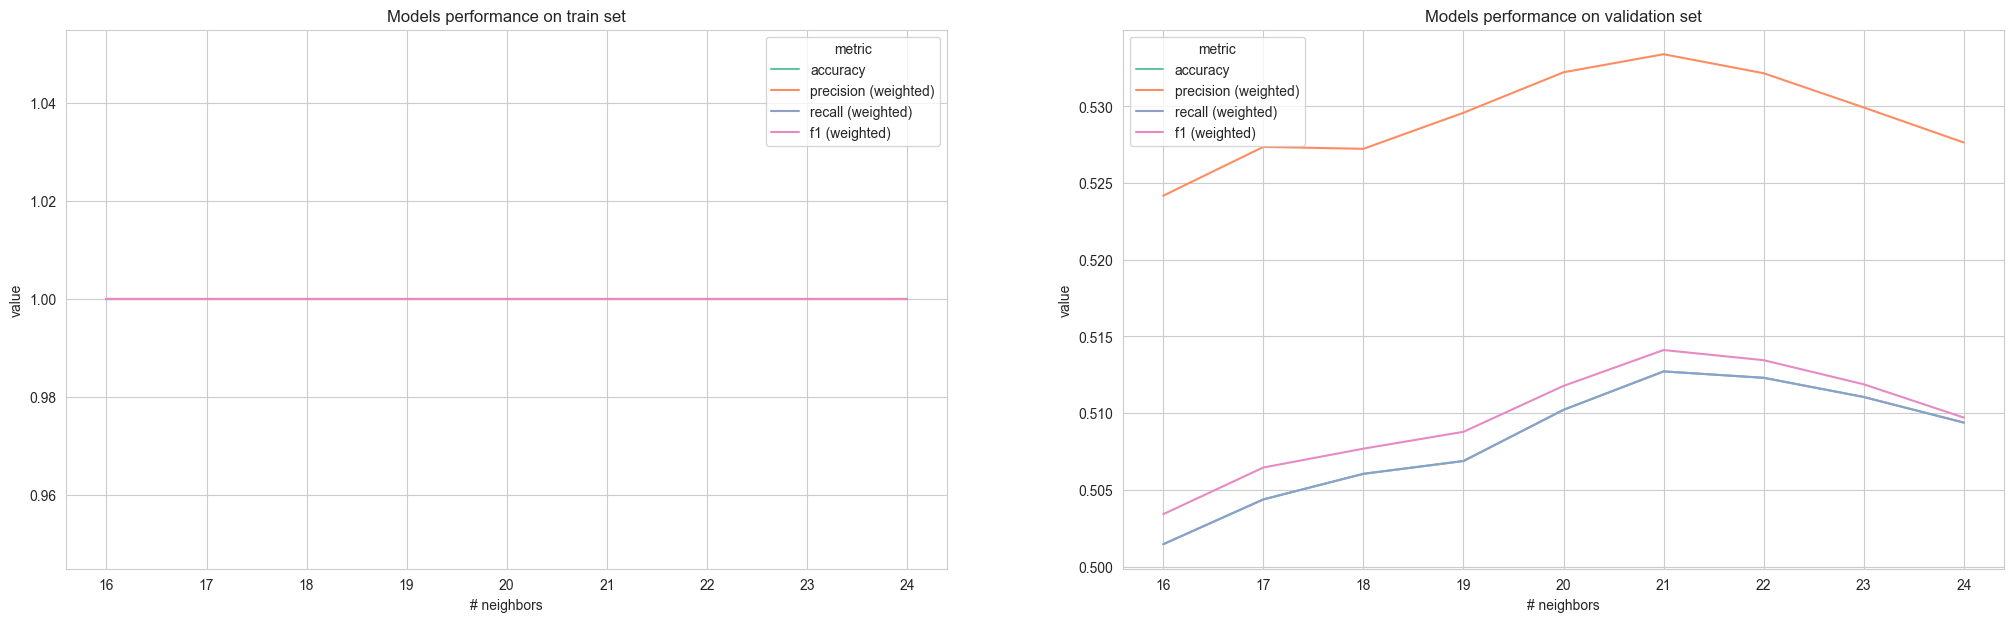

In [24]:
fig, axis = plt.subplots(1, 2, figsize=(25, 7))
sns.lineplot(data=train_set_results, x='# neighbors', y='value', hue='metric', ax=axis[0])
axis[0].set_title('Models performance on train set')
sns.lineplot(data=test_set_results, x='# neighbors', y='value', hue='metric', ax=axis[1])
axis[1].set_title('Models performance on validation set')
plt.show()

In [25]:
knn_clf = classification_utils.ClassifierFactory.create_instance(
    dataset=umap_distances_dataset,
    classifier=KNeighborsClassifier(n_neighbors=21, weights='distance', algorithm='auto', metric='precomputed'),
)

In [26]:
knn_clf.fit_classifier()

In [27]:
knn_clf.get_clf_evaluation().get_scores()

,train,val,test
accuracy,1.0,0.512724,0.508426
precision (weighted),1.0,0.533398,0.528118
recall (weighted),1.0,0.512724,0.508426
f1 (weighted),1.0,0.514117,0.508310


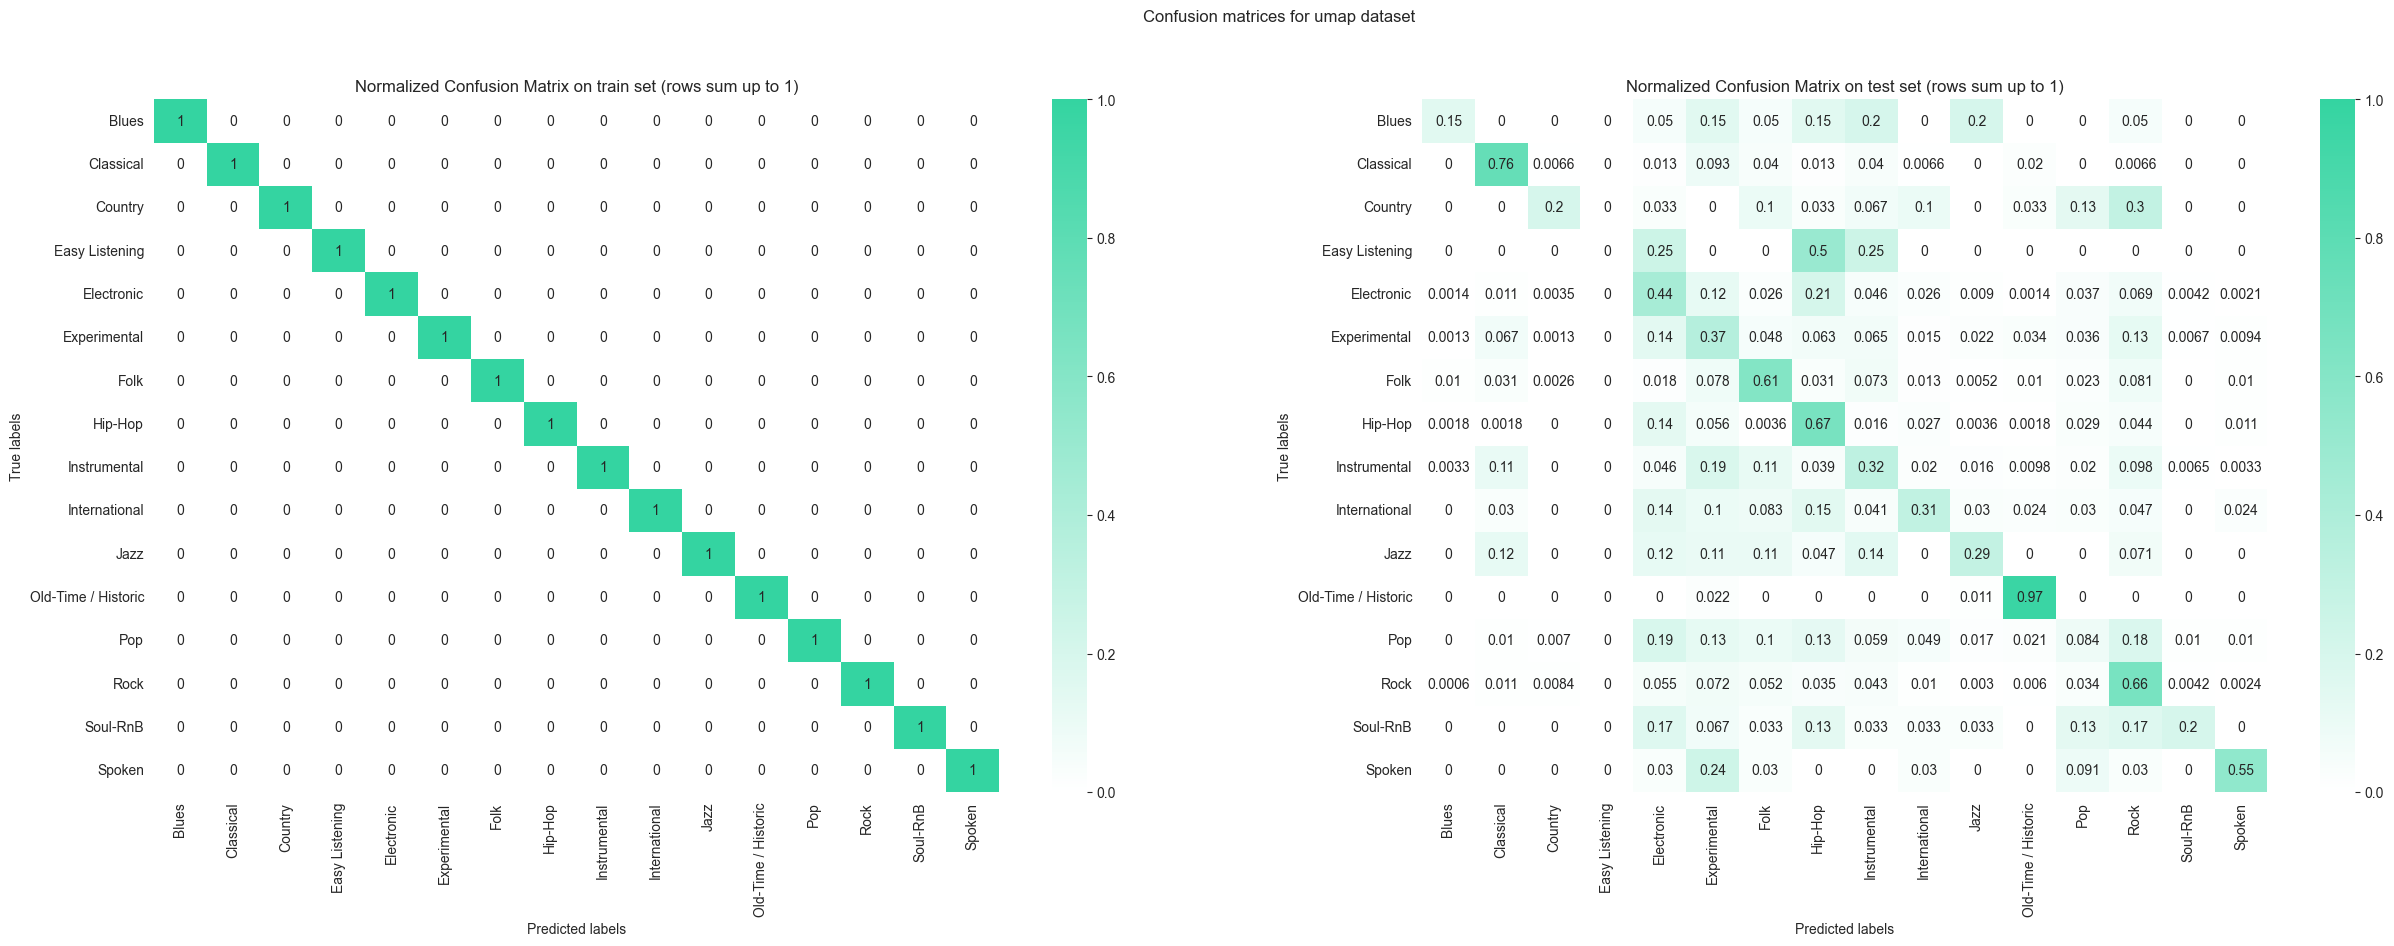

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
knn_clf.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
knn_clf.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Confusion matrices for umap dataset')
plt.show()

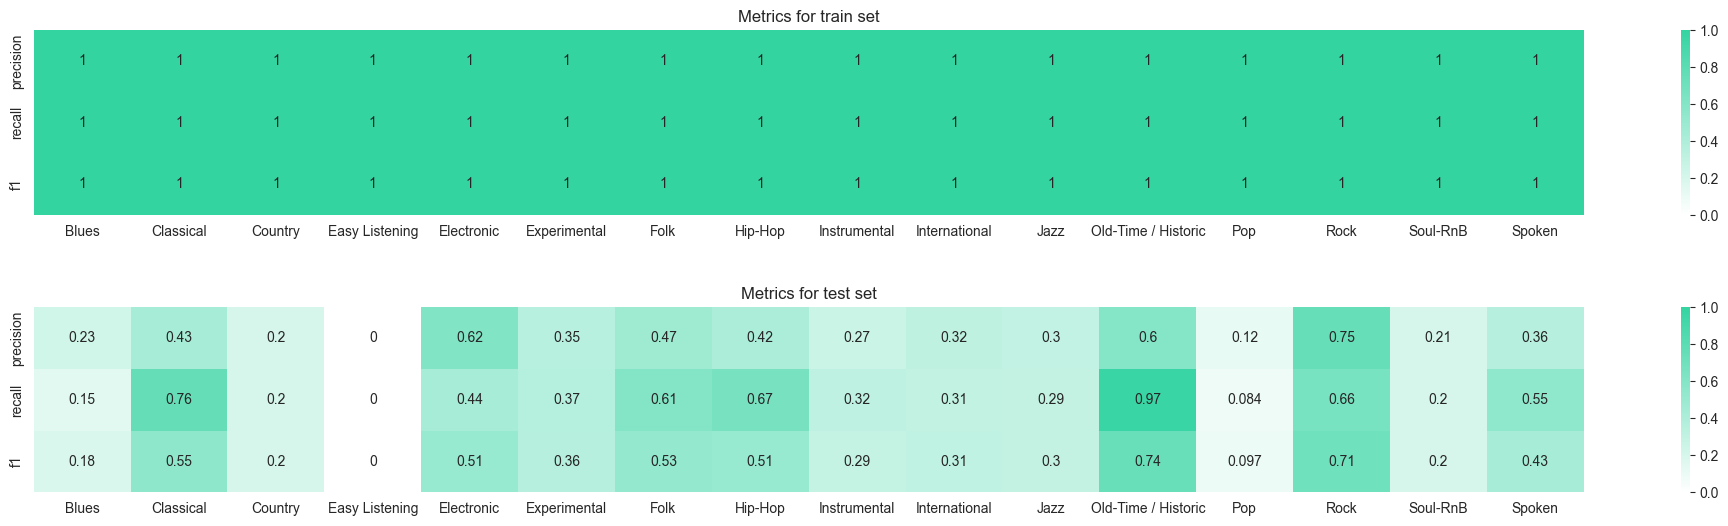

In [29]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
knn_clf.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
knn_clf.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()